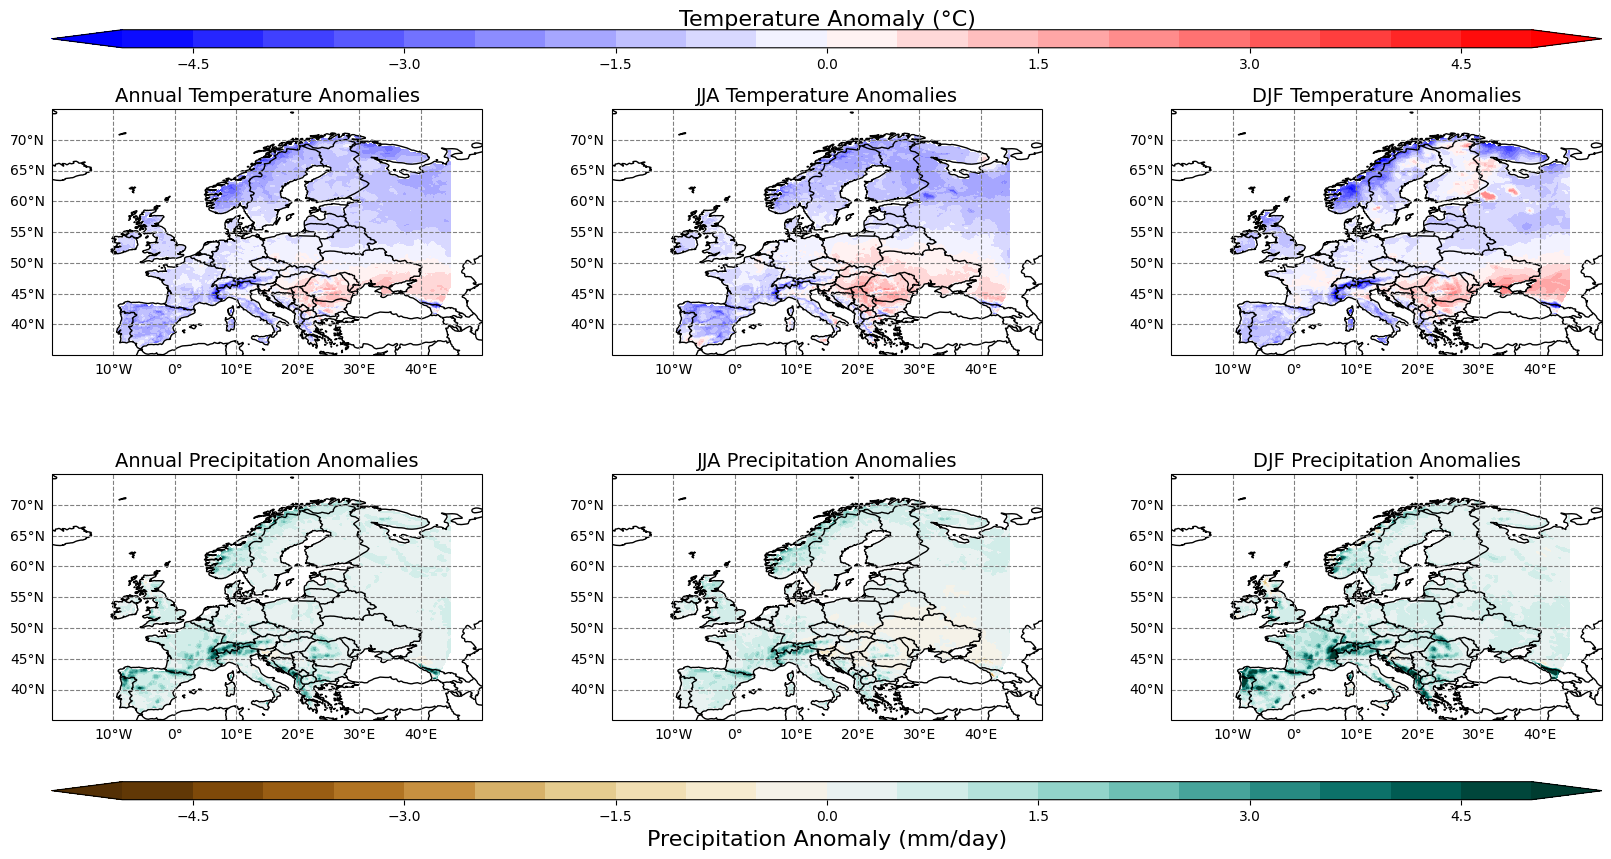

In [1]:
import xarray as xr
import numpy as np
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
import matplotlib.gridspec as gridspec

# Define a function to process and calculate anomalies (for temperature and precipitation)
def calculate_anomalies(historical_file, baseline_file, variable):
    # Load the historical simulation data
    historical_data = xr.open_dataset(historical_file)
    historical_var = historical_data[variable]  # Use 'tas' for temperature, 'pr' for precipitation

    # Load the baseline observation data
    observations_data = xr.open_dataset(baseline_file)
    observations_var = observations_data[variable]

    # Flatten the lat/lon grids of the observations
    obs_lon, obs_lat = np.meshgrid(observations_var.lon, observations_var.lat)
    obs_points = np.array([obs_lon.flatten(), obs_lat.flatten()]).T
    obs_values = observations_var.values.flatten()

    # Interpolate observations to the historical grid using SciPy's griddata
    historical_lon, historical_lat = np.meshgrid(historical_var.lon, historical_var.lat)
    interpolated_obs = interp.griddata(obs_points, obs_values, (historical_lon, historical_lat), method='linear')

    # Subtract the interpolated observations from the historical model data
    anomalies = historical_var.values - interpolated_obs

    # Convert the result back into an xarray DataArray
    anomalies_da = xr.DataArray(anomalies, dims=['lat', 'lon'], coords={'lat': historical_var.lat, 'lon': historical_var.lon})
    return anomalies_da

# Files for Annual, JJA, DJF for temperature (tas) and precipitation (pr)
data_files_temperature = [
    ('Annual.nc', 'Baseline Annual.nc'),
    ('JJA.nc', 'Baseline JJA.nc'),
    ('DJF.nc', 'Baseline DJF.nc')
]

data_files_precipitation = [
    ('Annual1.nc', 'Baseline Annual1.nc'),
    ('JJA1.nc', 'Baseline JJA1.nc'),
    ('DJF1.nc', 'Baseline DJF1.nc')
]

# Define a custom colormap with white at the center
colors = [
    (0, "blue"),    # Low values (cold) in blue
    (0.5, "white"), # Middle value (neutral) in white
    (1, "red")      # High values (warm) in red
]
cmap_temp = LinearSegmentedColormap.from_list("BlueWhiteRed", colors)

# Set up the figure and GridSpec layout with colorbars at the top and bottom
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(4, 3, height_ratios=[0.05, 1, 1, 0.05], wspace=0.3, hspace=0.02)

# Create axes for the 3 temperature and 3 precipitation plots
axes_temperature = [fig.add_subplot(gs[1, i], projection=ccrs.PlateCarree()) for i in range(3)]
axes_precipitation = [fig.add_subplot(gs[2, i], projection=ccrs.PlateCarree()) for i in range(3)]

# Set normalization with white at 0 for temperature
norm_temp = TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)

# Set colormap and normalization for precipitation (% change)
cmap_prec = plt.get_cmap('BrBG')
norm_prec = TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)

# Titles for temperature and precipitation subplots
titles_temperature = ['Annual Temperature Anomalies', 'JJA Temperature Anomalies', 'DJF Temperature Anomalies']
titles_precipitation = ['Annual Precipitation Anomalies', 'JJA Precipitation Anomalies', 'DJF Precipitation Anomalies']

# Loop through the data files and axes to plot temperature anomalies
for i, (historical_file, baseline_file) in enumerate(data_files_temperature):
    anomalies_da = calculate_anomalies(historical_file, baseline_file, 'tas')
    contour_temp = axes_temperature[i].contourf(
        anomalies_da.lon, anomalies_da.lat, anomalies_da, cmap=cmap_temp, norm=norm_temp,
        levels=np.linspace(-5, 5, 21), extend='both', transform=ccrs.PlateCarree()
    )
    axes_temperature[i].set_extent([-20, 50, 35, 75], crs=ccrs.PlateCarree())
    axes_temperature[i].coastlines()
    axes_temperature[i].add_feature(cfeature.BORDERS)
    gl = axes_temperature[i].gridlines(draw_labels=True, linestyle="--", color="gray")
    gl.top_labels = False
    gl.right_labels = False
    axes_temperature[i].set_title(titles_temperature[i], fontsize=14)

# Loop through the data files and axes to plot precipitation anomalies
for i, (historical_file, baseline_file) in enumerate(data_files_precipitation):
    anomalies_da = calculate_anomalies(historical_file, baseline_file, 'pr')
    contour_prec = axes_precipitation[i].contourf(
        anomalies_da.lon, anomalies_da.lat, anomalies_da, cmap=cmap_prec, norm=norm_prec,
        levels=np.linspace(-5, 5, 21), extend='both', transform=ccrs.PlateCarree()
    )
    axes_precipitation[i].set_extent([-20, 50, 35, 75], crs=ccrs.PlateCarree())
    axes_precipitation[i].coastlines()
    axes_precipitation[i].add_feature(cfeature.BORDERS)
    gl = axes_precipitation[i].gridlines(draw_labels=True, linestyle="--", color="gray")
    gl.top_labels = False
    gl.right_labels = False
    axes_precipitation[i].set_title(titles_precipitation[i], fontsize=14)

# Add colorbars with improved label placement
cbar_ax_temp = fig.add_subplot(gs[0, :])
cbar_temp = fig.colorbar(contour_temp, cax=cbar_ax_temp, orientation='horizontal', shrink=0.8, pad=0.2)
cbar_ax_temp.text(0.5, 1.25, 'Temperature Anomaly (°C)', ha='center', fontsize=16, transform=cbar_ax_temp.transAxes)

cbar_ax_prec = fig.add_subplot(gs[3, :])
cbar_prec = fig.colorbar(contour_prec, cax=cbar_ax_prec, orientation='horizontal', label='Precipitation Anomaly (mm/day)', shrink=0.8, pad=0.2)
cbar_prec.set_label('Precipitation Anomaly (mm/day)', fontsize=16)

# Save the figure as a high-quality PNG image
plt.savefig('high_quality_plot_with_white_center.png', dpi=300, bbox_inches='tight')
plt.show()